# Imports

In [1]:
from typing import Tuple, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import ndarray, dtype
from pandas import Series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import statsmodels.api as sm

# Constants

In [2]:
_month_to_number = {'Spring': 3, 'Summer': 6, 'Fall': 9, 'Winter': 12}
_number_to_month = {_month_to_number[k]: k for k in _month_to_number}
_figsize = (14, 6)

# Util

In [3]:
def convert_std(s: str) -> pd.Timestamp | None:
    try:
        season, year = s.split()
        month = _month_to_number[season]
        return pd.Timestamp(year=int(year), month=month, day=1)
    except Exception:
        # Если возникает ошибка, возвращаем None
        return None

def convert_dts(dt: pd.Timestamp) -> str:
    return _number_to_month[dt.month.real] + " " + str(dt.year.real)

# Data Preparation

In [4]:
def get_anime_count_with_known_premiere() -> pd.Series:
    anime_data = pd.read_csv('mal_anime.csv')
    anime_data = anime_data[anime_data['premiered'] != 'Unknown'][anime_data['premiered'] != '?']
    anime_data['season'] = anime_data['premiered'].apply(convert_std)
    anime_count_by_season: pd.Series = anime_data.groupby('season').size()
    return anime_count_by_season

In [5]:
def prepare_data() -> tuple[Series, Any]:
    anime_count_by_season: pd.Series = get_anime_count_with_known_premiere()
    print(anime_count_by_season.head())

    start_date = pd.Timestamp('1990-03-01')
    end_date = pd.Timestamp('2018-03-01')
    subset_anime_count = anime_count_by_season[
        (anime_count_by_season.index >= start_date) & (anime_count_by_season.index <= end_date)]
    print(subset_anime_count.head(10))
    show_bar(subset_anime_count)
    show_line(subset_anime_count)
    return anime_count_by_season, subset_anime_count

# Graphics Methods

In [6]:
def show_line(subset_anime_count: pd.Series, save=False) -> None:
    # Пример данных
    x = range(len(subset_anime_count.index))  # x-координаты
    y = subset_anime_count.values  # y-координаты
    plt.figure(figsize=_figsize)
    # Создание графика как кривой линии
    plt.plot(x, y)
    plt.title('Количество вышедших аниме по сезонам')
    plt.xlabel('Сезон')
    plt.ylabel('Количество аниме')
    plt.xticks(x, subset_anime_count.index.map(convert_dts), rotation=45, ha='right', fontsize=8)
    plt.tight_layout()

    if save:
        # Сохранение графика в файл
        plt.savefig('anime_seasons_line.png')

    # Отображение графика
    plt.show()

In [7]:
def show_line2(all_data: pd.Series, s: str) -> None:
    plt.figure(figsize=(10, 6))
    plt.plot(all_data, label=s)
    plt.title('TimeSeries demonstration')
    plt.legend()
    plt.show()

In [8]:
def show_bar(subset_anime_count: pd.Series, save=False) -> None:
    subset_anime_count.plot(kind='bar', figsize=_figsize)
    plt.title('Количество вышедших аниме по сезонам')
    plt.xlabel('Сезон')
    plt.ylabel('Количество аниме')
    plt.xticks(range(len(subset_anime_count.index)),
               subset_anime_count.index.map(convert_dts), rotation=45, ha='right',
               fontsize=8)
    plt.tight_layout()
    if save:
        plt.savefig('anime_seasons.png')
    plt.show()

# Running

C:\Users\mansu\AppData\Local\Temp\ipykernel_19472\3912431722.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  anime_data = anime_data[anime_data['premiered'] != 'Unknown'][anime_data['premiered'] != '?']


season
1961-03-01    1
1962-06-01    1
1963-09-01    4
1963-12-01    1
1964-06-01    2
dtype: int64
season
1990-03-01     9
1990-06-01     3
1990-09-01     9
1990-12-01     8
1991-03-01    15
1991-06-01     1
1991-09-01    13
1991-12-01     9
1992-03-01    18
1992-06-01     2
dtype: int64


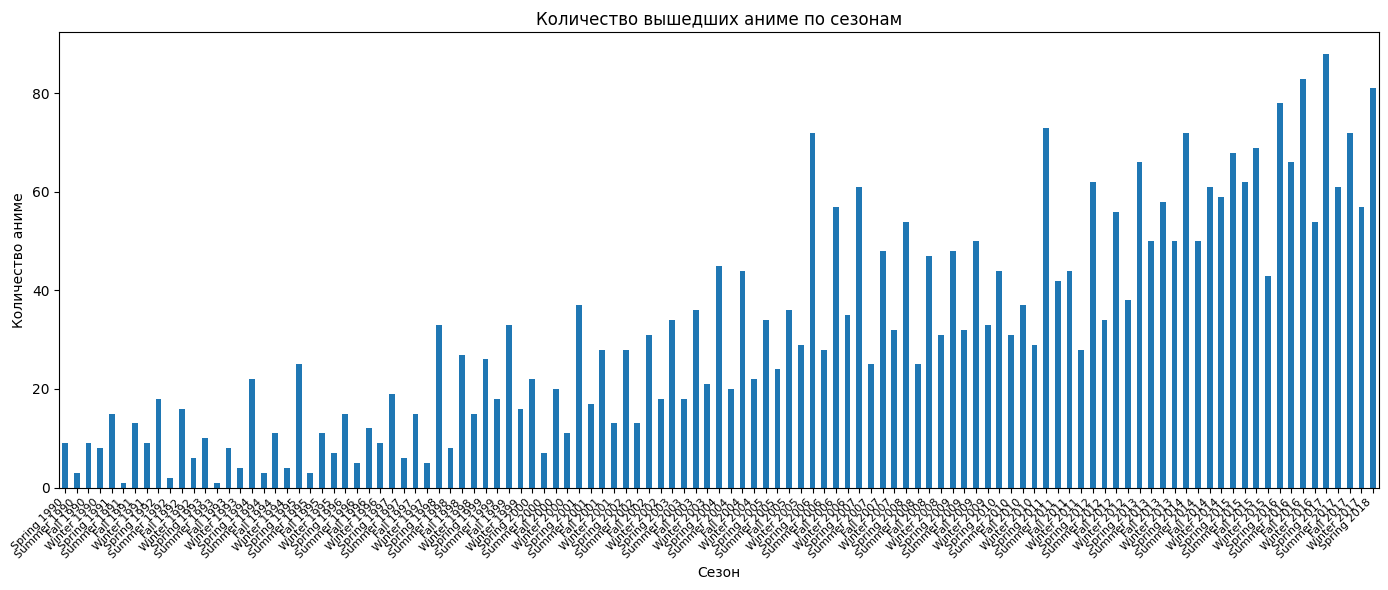

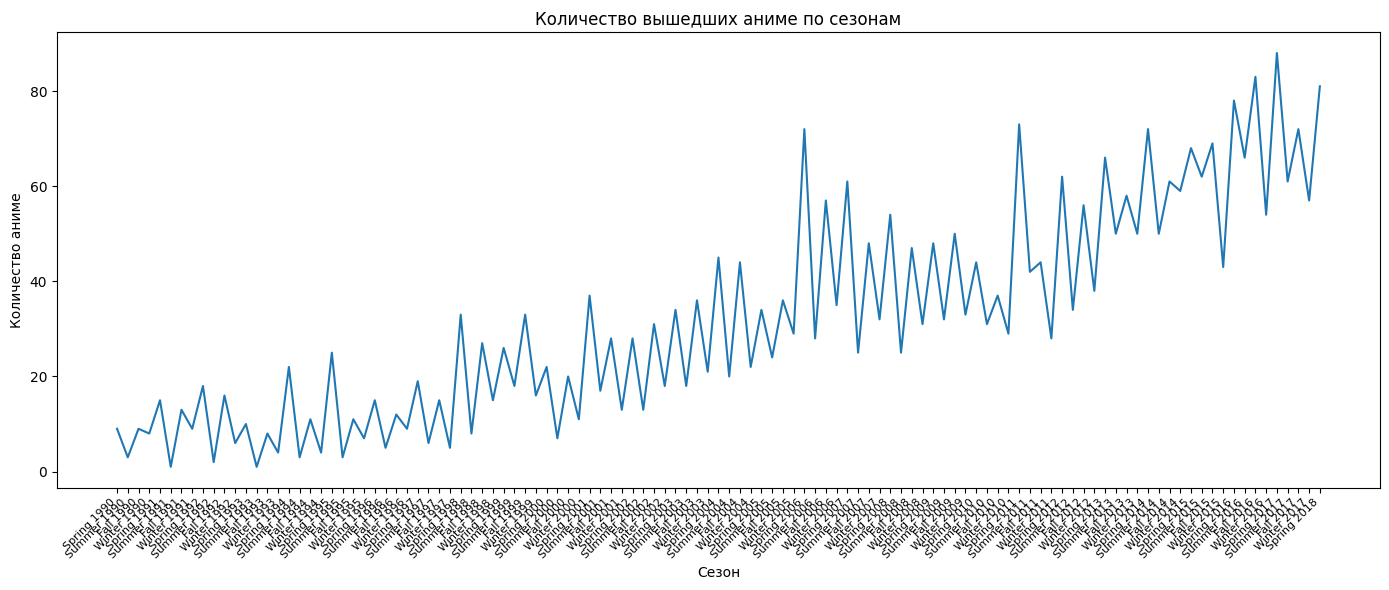

In [9]:
all_data, data = prepare_data()

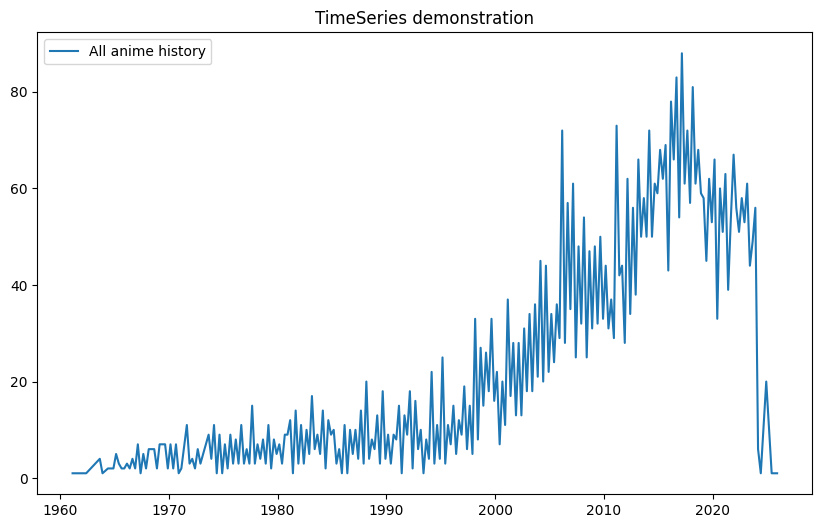

In [10]:
show_line2(all_data, "All anime history")

In [11]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [12]:
def check_stationarity(timeseries: pd.Series, s: str | None = None) -> None:
    if s:
        print("------------")
        print(s)
    result = adfuller(timeseries.dropna())
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [13]:
check_stationarity(train)

ADF Statistic: -0.22383522816526044
p-value: 0.9356202418083983
Non-Stationary
	1%: -3.513
	5%: -2.897
	10%: -2.586


## Checking multiplicative decomposition

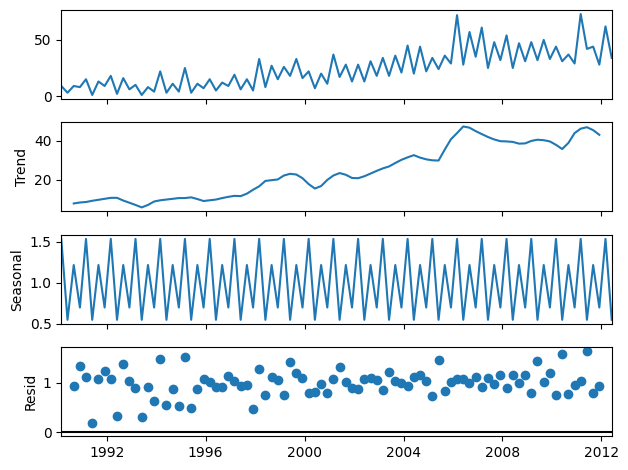

In [14]:
decompositionM = sm.tsa.seasonal_decompose(train, model='multiplicative')
decompositionM.plot()
plt.show()

In [15]:
check_stationarity(decompositionM.resid)

ADF Statistic: -3.4384473966245928
p-value: 0.009715977731389465
Stationary
	1%: -3.513
	5%: -2.897
	10%: -2.586


# Checking additive decomposition

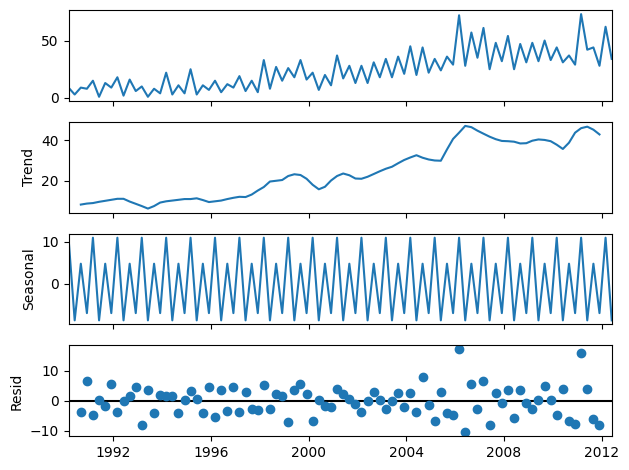

In [16]:
decompositionA = sm.tsa.seasonal_decompose(train)
decompositionA.plot()
plt.show()

In [17]:
check_stationarity(decompositionA.resid)

ADF Statistic: -5.110749193197346
p-value: 1.3337809007566446e-05
Stationary
	1%: -3.523
	5%: -2.902
	10%: -2.588


In [18]:
decompositionA.resid

season
1990-03-01         NaN
1990-06-01         NaN
1990-09-01   -3.759199
1990-12-01    6.490801
1991-03-01   -4.696158
                ...   
2011-06-01    3.839556
2011-09-01   -6.134199
2011-12-01   -8.009199
2012-03-01         NaN
2012-06-01         NaN
Name: resid, Length: 90, dtype: float64

# Autocorrelation

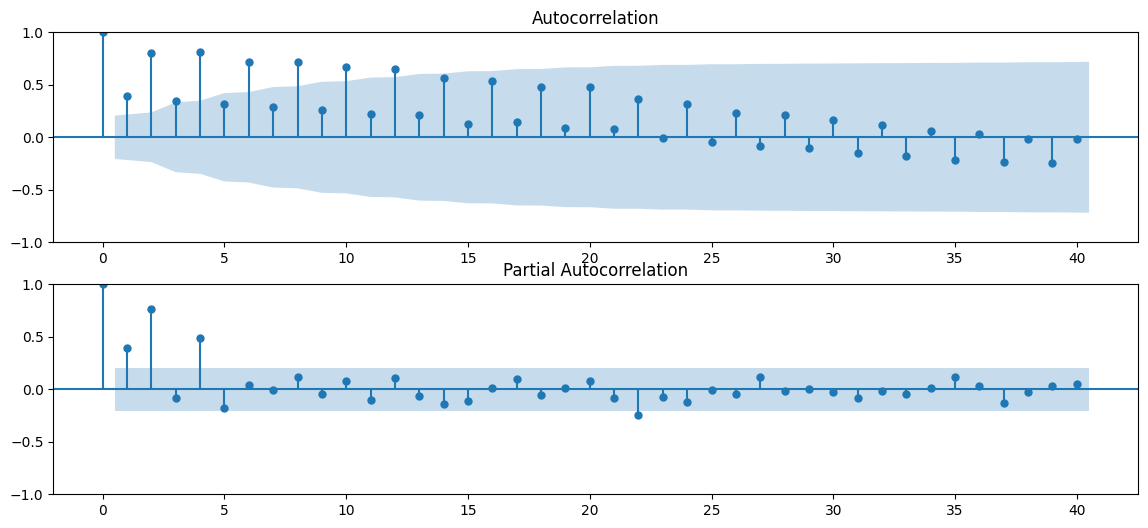

In [19]:
def draw_acf(ts: pd.Series) -> None :
    fig = plt.figure(figsize=_figsize)
    ax1 = fig.add_subplot(211)
    fig = plot_acf(ts,lags=40,ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(ts,lags=40,ax=ax2)

draw_acf(train)

# Parameters

In [20]:
order = (2, 1, 2)
seasonal_order = (1, 1, 1, 4)
(p, d, q) = order
(P, D, Q, s) = seasonal_order

In [21]:
# SARIMA (lib)

In [22]:
sar = SARIMAX(train, order=order, seasonal_order=seasonal_order)
results = sar.fit()
print(results.summary())
forecast = results.forecast(steps = len(test))

D:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
D:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   90
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 4)   Log Likelihood                -284.352
Date:                             Wed, 06 Mar 2024   AIC                            582.704
Time:                                     13:03:00   BIC                            599.802
Sample:                                 03-01-1990   HQIC                           589.581
                                      - 06-01-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8306      0.178     -4.661      0.000      -1.180      -0.481
ar.L2          0.1693      

D:\Python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='season'>

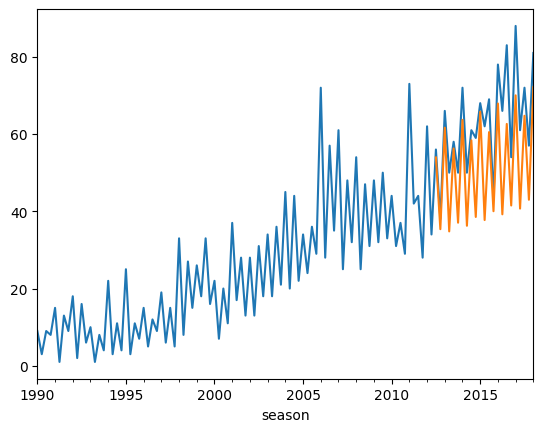

In [23]:
ax = data.plot()
forecast.plot(ax = ax)

In [24]:
mape = mean_absolute_percentage_error(test, forecast)
print(f'MAPE: {mape}')

MAPE: 0.18112491911247378


# SARIMA (my version)

In [25]:
train.head()

season
1990-03-01     9
1990-06-01     3
1990-09-01     9
1990-12-01     8
1991-03-01    15
dtype: int64

In [26]:
check_stationarity(train)

ADF Statistic: -0.22383522816526044
p-value: 0.9356202418083983
Non-Stationary
	1%: -3.513
	5%: -2.897
	10%: -2.586


In [27]:
train.head()

season
1990-03-01     9
1990-06-01     3
1990-09-01     9
1990-12-01     8
1991-03-01    15
dtype: int64

In [28]:
d_train = train - train.shift(d)
d_train.dropna(inplace=True)
d_train.head()

season
1990-06-01    -6.0
1990-09-01     6.0
1990-12-01    -1.0
1991-03-01     7.0
1991-06-01   -14.0
dtype: float64

In [29]:
check_stationarity(d_train)

ADF Statistic: -5.727361375060301
p-value: 6.722920937096911e-07
Stationary
	1%: -3.513
	5%: -2.897
	10%: -2.586


In [30]:
if D == 0:
    D_train = d_train
else:
    D_train = d_train - d_train.shift(D * s)
    D_train.dropna(inplace=True)
D_train.head()

season
1991-06-01   -8.0
1991-09-01    6.0
1991-12-01   -3.0
1992-03-01    2.0
1992-06-01   -2.0
dtype: float64

In [31]:
check_stationarity(D_train)

ADF Statistic: -6.002052243878668
p-value: 1.6484617246847572e-07
Stationary
	1%: -3.521
	5%: -2.901
	10%: -2.588


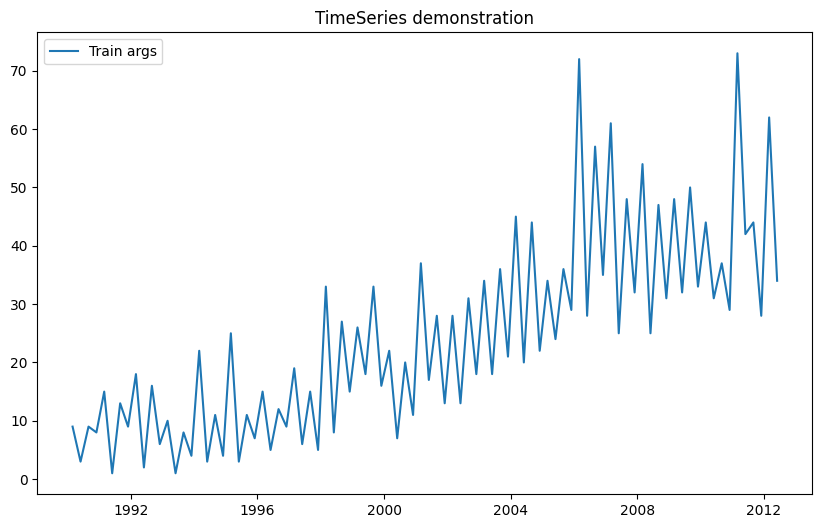

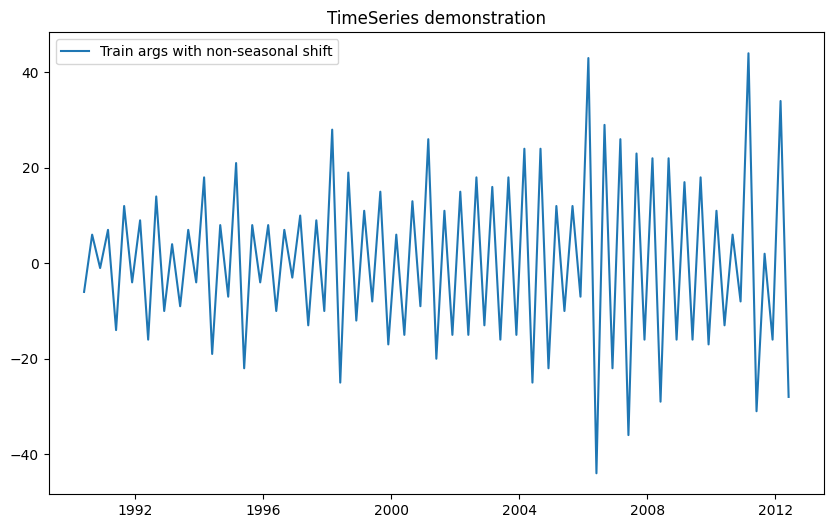

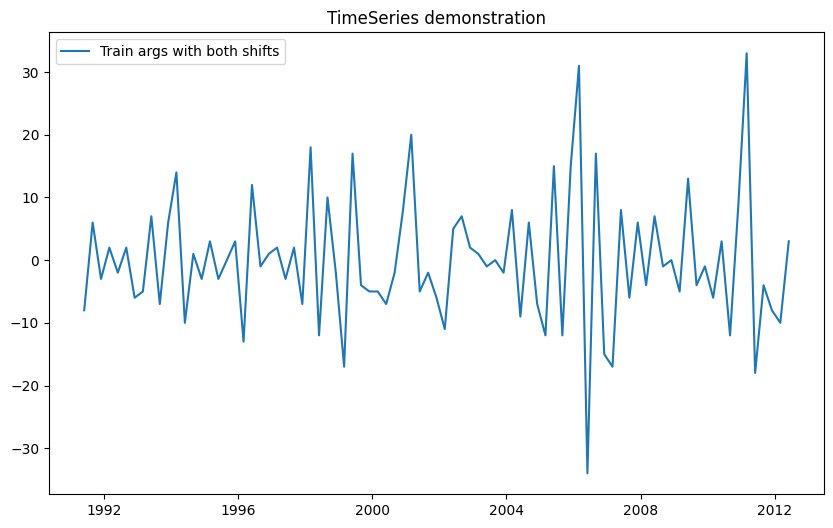

In [32]:
show_line2(train, "Train args")
show_line2(d_train, "Train args with non-seasonal shift")
show_line2(D_train, "Train args with both shifts")

In [33]:
print(order)
print(seasonal_order)

(2, 1, 2)
(1, 1, 1, 4)


In [51]:
import numpy as np
from scipy.optimize import minimize

def count_value(par, ts, t, m):
    v = par[0]
    for i in range(1, p + 1):
        v += par[i] * ts.iloc[t - i]
    for i in range(1, q + 1):
        v += par[p + i] * count_error(par, ts, t - i, m)
    for i in range(1, P + 1):
        v += par[p + q + i] * ts.iloc[t - i * s]
    for i in range(1, Q + 1):
        v += par[p + q + P + i] * count_error(par, ts, t - i * s, m)
    return v
    
def count_error(par, ts, t, m):
    if t in m:
        return m[t]
    if max(p, q, P * s, Q * s) > t or t >= ts.size:
        return 0
    v = ts.iloc[t] - count_value(par, ts, t, m)
    m[t] = v
    return v

# Целевая функция, где x - вектор параметров, а a и b - фиксированные параметры
def objective_function(x, ts: pd.Series):
    e = 0
    m = {}
    for i in range(max(p, q, P * s, Q * s), ts.size):
        e += count_error(x, ts, i, m) ** 2
    return e

initial_guess = [0.42 for _ in range(1 + p + q + P + Q)]
initial_guess[0] = D_train.mean()

result = minimize(objective_function, initial_guess, args=D_train)

# Вывод результатов
print("Минимум функции:", result.x)
print("Значение функции в минимуме:", result.fun)

Минимум функции: [ 0.95994814 -0.27931715 -0.58266795  0.16618979  0.80809726 -0.1315313
 -0.67141865]
Значение функции в минимуме: 3797.3957869750516


In [52]:
m = {}
D_res = pd.Series(D_train)
st = D_res.size
# print(D_res.index[-1])
for i in range(len(test)):
    # print(D_res.index[-1] + pd.DateOffset(months=3))
    D_res[D_res.index[-1] + pd.DateOffset(months=3)] = count_value(result.x, D_res, st + i, m)

<Axes: xlabel='season'>

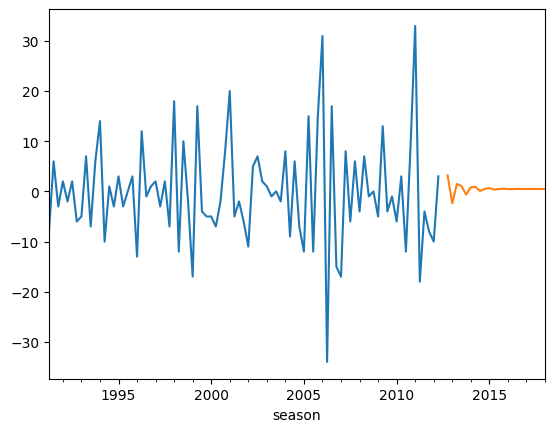

In [53]:
ax = D_train.plot()
D_res[st + 1:].plot(ax = ax)

In [54]:
if D == 0:
    d_res = D_res
else:
    d_res = pd.Series(d_train)
    st = d_res.size
    for i in range(D_res.size):
        d_res[D_res.index[i]] = d_res[D_res.index[i] - D * s * pd.DateOffset(months=3)] + D_res.iloc[i]

<Axes: xlabel='season'>

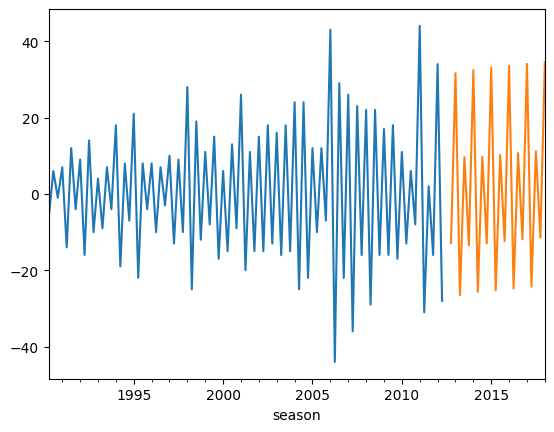

In [55]:
ax = d_train.plot()
d_res[st + 1:].plot(ax = ax)

In [56]:
res = pd.Series(train)
st = res.size
for i in range(d_res.size):
    res[d_res.index[i]] = res[d_res.index[i] - d * pd.DateOffset(months=3)] + d_res.iloc[i]
res

season
1990-03-01     9.000000
1990-06-01     3.000000
1990-09-01     9.000000
1990-12-01     8.000000
1991-03-01    15.000000
                ...    
2017-03-01    82.096111
2017-06-01    57.811144
2017-09-01    68.996157
2017-12-01    57.560640
2018-03-01    92.089368
Length: 113, dtype: float64

<Axes: xlabel='season'>

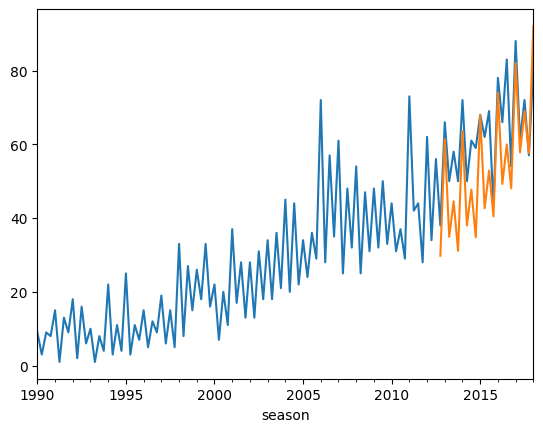

In [57]:
ax = data.plot()
res[st + 1:].plot(ax = ax)

In [58]:
mape = mean_absolute_percentage_error(test, res[st:])
print(f'MAPE: {mape}')

MAPE: 0.17515520621368824
